In [1]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
input_type = 'sample'
spark = SparkSession.builder\
         .master("local[2]")\
         .appName("Colab")\
         .config('spark.ui.port', '4050').config("spark.executor.memory", "7g").getOrCreate()
default_parallelism = spark.sparkContext.defaultParallelism
print(f"Default Parallelism: {default_parallelism}")
spark

Default Parallelism: 2


### Initializing Spark

### Imports

In [2]:
from pyspark.sql import Row
from pyspark.sql.functions import expr, lower, regexp_replace, split, udf, regexp_extract, col,size,collect_list,count,explode,when,rand
from pyspark.sql.types import ArrayType, StringType, DoubleType
from pyspark.ml.feature import CountVectorizer, HashingTF, IDF, Tokenizer, StopWordsRemover
from pyspark.ml.classification import LogisticRegression, LinearSVC, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F
from pyspark.sql.window import Window  # Import the Window class

import matplotlib.pyplot as plt
import numpy as np

### Data taken from https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/#code
### This contains 3 kinds of data. 
### 1. Total review data containing review text, review summary, overall (Sizes of the order of GBs - books data is 6.5GB)
### 2. K-Core data - Each product will have K ratings given by users (It's a shortened version of 1st data set)
### 3. Metadata of the products reviewed. Contains some useful columns like features, also_buy etc.
### The data is further split into categories (Video games, Books, kindle review, software, clothes etc)

### Data visualization - metadata (3rd one)

In [121]:
metadata_df = spark.read.json('D:\\DE\\meta_Appliances.json')

# Show the DataFrame
metadata_df.show(5)

+--------+--------------------+----------+--------------+--------------------+-----------------+--------------------+--------------------+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-----+--------------------+
|also_buy|           also_view|      asin|         brand|            category|             date|         description|             details|             feature|fit|            imageURL|     imageURLHighRes|            main_cat|               price|                rank|similar_item|               tech1|tech2|               title|
+--------+--------------------+----------+--------------+--------------------+-----------------+--------------------+--------------------+--------------------+---+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------------+-----+--------------------+
|      []|

#### Schema for metadata - This would be same for all categories

In [86]:
metadata_df.printSchema()

root
 |-- also_buy: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- also_view: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- asin: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- date: string (nullable = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: struct (nullable = true)
 |    |-- \n    Item Weight: \n    : string (nullable = true)
 |    |-- \n    Product Dimensions: \n    : string (nullable = true)
 |    |-- ASIN:: string (nullable = true)
 |    |-- ASIN: : string (nullable = true)
 |    |-- Batteries: string (nullable = true)
 |    |-- Domestic Shipping: : string (nullable = true)
 |    |-- International Shipping: : string (nullable = true)
 |    |-- Item model number:: string (nullable = true)
 |    |-- Publisher:: string (nullable = true)
 |    |-- Ship

#### Selection and description of useful columns for the upcoming tasks
asin -> product-ID (unique and never null)   
also_buy -> also_buy (It's empty a lot of times - Can't be used directly for recommendation systems - We need to figure out a way to fill empty array)  
also_view -> also_view (It's empty a lot of times - Can't be used directly for recommendation systems - We need to figure out a way to fill empty array)  
main_cat -> category (main category of the product described)  
description -> description (description of the product - empty lot of times)  
price -> price (of the product)  
title -> title (of the product)  
rank -> rank (#27262 in Total & #333 in games etc.)
brand -> brand (of the product)

In [127]:
metadata_df_2 = metadata_df['asin','also_buy','also_view','main_cat','description','price','title','rank','brand']

##### Let's see the number of missing values in each column in the selected data frame - this is important for doing future tasks - We may have to do Imputation

In [123]:
def count_missing(df):
    schema = df.schema
    print(f"Total rows in the DF: {df.count()}")
    print("-" * 30)
    
    # Iterate through columns and print information
    for field in schema.fields:
        column_name = field.name
        data_type = str(field.dataType)
        empty_null_count = count_empty_null(column_name, data_type,df)
        print(f"Column: {column_name}, Empty/Null Count: {empty_null_count}")

    # Define functions to count empty and null values
def count_empty_null(column_name, data_type,df):
    if (data_type == "StringType()") | ("ouble" in data_type):
        empty = df.filter((col(column_name) == "")).count()
        nc = df.filter((col(column_name).isNull())).count()
        print(f"Empty: {empty} and Null: {nc}")
        return empty+nc
    elif data_type == "ArrayType(StringType(), True)":
        return df.filter((col(column_name).isNull()) | (size(col(column_name)) == 0)).count()
    else:
        return 0

#count_missing(metadata_df_2)

#### Imputing columns title and dropping products without a category main_cat (with NA)

In [129]:
columns_to_fill = ["title"]
metadata_df_2 = metadata_df_2.withColumn("main_cat", F.when(F.col("main_cat").contains("&amp;"), F.regexp_replace("main_cat", "&amp;", "&")).otherwise(F.col("main_cat")))
metadata_df_2 = metadata_df_2.withColumn("main_cat", F.when(F.col("main_cat").contains("<"), "AMAZON FASHION").otherwise(F.col("main_cat")))
metadata_df_2 = metadata_df_2.withColumn("main_cat", F.when((F.col("main_cat")==""), "NA_CATEGORY").otherwise(F.col("main_cat")))
metadata_df_2 = metadata_df_2.withColumn("brand", F.when((F.col("brand")==""), "NA_BRAND").otherwise(F.col("brand")))
metadata_df_2 = metadata_df_2.withColumn("title", F.when((F.col("title")==""), "NO_TITLE").otherwise(F.col("title")))
metadata_df_2.na.drop(subset=["main_cat"])
#count_missing(metadata_df_2)
metadata_df_2.select('main_cat').distinct().collect()

[Row(main_cat='All Electronics'),
 Row(main_cat='Home Audio & Theater'),
 Row(main_cat='Pet Supplies'),
 Row(main_cat='Toys & Games'),
 Row(main_cat='Baby'),
 Row(main_cat='Sports & Outdoors'),
 Row(main_cat='Automotive'),
 Row(main_cat='Books'),
 Row(main_cat='Amazon Home'),
 Row(main_cat='Industrial & Scientific'),
 Row(main_cat='Health & Personal Care'),
 Row(main_cat='Cell Phones & Accessories'),
 Row(main_cat='Arts, Crafts & Sewing'),
 Row(main_cat='Tools & Home Improvement'),
 Row(main_cat='All Beauty'),
 Row(main_cat='Office Products'),
 Row(main_cat='Appliances'),
 Row(main_cat='Musical Instruments'),
 Row(main_cat='NA_CATEGORY'),
 Row(main_cat='Computers'),
 Row(main_cat='Grocery'),
 Row(main_cat='Camera & Photo'),
 Row(main_cat='AMAZON FASHION')]

#### We can't directly use also_buy column to build a recommendation system as it is incomplete. 
#### We need to find possible ways to fill up empty arrays
#### The data also contains also_buy and also_view values coming from other categories

### Review data

In [130]:
review_df = spark.read.json('D:\\DE\\Appliances.json')
review_df = review_df.na.drop(subset=["reviewText","summary"])
review_df.show(5)

+----------+-----+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------------+--------------+--------+----+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|               style|             summary|unixReviewTime|verified|vote|
+----------+-----+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------------+--------------+--------+----+
|1118461304| NULL|    5.0|Not one thing in ...|11 27, 2013|A3NHUQ33CFH3VM|              Greeny|{NULL, NULL, NULL...|Clear on what lea...|    1385510400|   false|   2|
|1118461304| NULL|    5.0|I have enjoyed Dr...| 11 1, 2013|A3SK6VNBQDNBJE|     Leif C. Ulstrup|{NULL, NULL, NULL...|Becoming more inn...|    1383264000|   false|NULL|
|1118461304| NULL|    5.0|Alan Gregerman be...|10 10, 2013|A3SOFHUR27FO3K|Harry Gilbert Mil...|{NULL, NULL, NULL...|The World from Di...|    1381363200|   false|NULL

#### Relevant columns
asin-> productID  
reviewerID -> unique id of reviewer  
overall -> contains rating (between 1 and 5 - ratings are always available for all reviews)  
reviewText -> actual review of the user  
unixReviewingTime -> Time of the review  
vote -> votes obtained for the particular review - we can use it for weighing the review

In [131]:
review_df = review_df['asin','vote','overall','reviewerID','reviewText','summary','unixReviewTime']

##### If vote column is null, we will replace it with 0

In [132]:
review_df = review_df.fillna("0",subset=["vote"])
review_df.show(5)

+----------+----+-------+--------------+--------------------+--------------------+--------------+
|      asin|vote|overall|    reviewerID|          reviewText|             summary|unixReviewTime|
+----------+----+-------+--------------+--------------------+--------------------+--------------+
|1118461304|   2|    5.0|A3NHUQ33CFH3VM|Not one thing in ...|Clear on what lea...|    1385510400|
|1118461304|   0|    5.0|A3SK6VNBQDNBJE|I have enjoyed Dr...|Becoming more inn...|    1383264000|
|1118461304|   0|    5.0|A3SOFHUR27FO3K|Alan Gregerman be...|The World from Di...|    1381363200|
|1118461304|   0|    5.0|A1HOG1PYCAE157|Alan Gregerman is...|Strangers are You...|    1381276800|
|1118461304|  10|    5.0|A26JGAM6GZMM4V|As I began to rea...|How and why it is...|    1378512000|
+----------+----+-------+--------------+--------------------+--------------------+--------------+
only showing top 5 rows



#### Getting sentiment extracted

The methodology: If rating is 1 and 2 (Negative)  
If rating is 5 and 4 (Positive)  
For 3 we will use pretrained LR model

In [133]:
loaded_model = PipelineModel.load('lrTfIdf42')

In [134]:
review_df = review_df.withColumn('text',F.concat(F.col('summary'),F.lit(" "),F.col('reviewText')))
review_df.show(5)

+----------+----+-------+--------------+--------------------+--------------------+--------------+--------------------+
|      asin|vote|overall|    reviewerID|          reviewText|             summary|unixReviewTime|                text|
+----------+----+-------+--------------+--------------------+--------------------+--------------+--------------------+
|1118461304|   2|    5.0|A3NHUQ33CFH3VM|Not one thing in ...|Clear on what lea...|    1385510400|Clear on what lea...|
|1118461304|   0|    5.0|A3SK6VNBQDNBJE|I have enjoyed Dr...|Becoming more inn...|    1383264000|Becoming more inn...|
|1118461304|   0|    5.0|A3SOFHUR27FO3K|Alan Gregerman be...|The World from Di...|    1381363200|The World from Di...|
|1118461304|   0|    5.0|A1HOG1PYCAE157|Alan Gregerman is...|Strangers are You...|    1381276800|Strangers are You...|
|1118461304|  10|    5.0|A26JGAM6GZMM4V|As I began to rea...|How and why it is...|    1378512000|How and why it is...|
+----------+----+-------+--------------+--------

In [135]:
columns_to_drop = ["reviewText","summary"]
review_df = review_df.drop(*columns_to_drop)
review_df.show(5)

+----------+----+-------+--------------+--------------+--------------------+
|      asin|vote|overall|    reviewerID|unixReviewTime|                text|
+----------+----+-------+--------------+--------------+--------------------+
|1118461304|   2|    5.0|A3NHUQ33CFH3VM|    1385510400|Clear on what lea...|
|1118461304|   0|    5.0|A3SK6VNBQDNBJE|    1383264000|Becoming more inn...|
|1118461304|   0|    5.0|A3SOFHUR27FO3K|    1381363200|The World from Di...|
|1118461304|   0|    5.0|A1HOG1PYCAE157|    1381276800|Strangers are You...|
|1118461304|  10|    5.0|A26JGAM6GZMM4V|    1378512000|How and why it is...|
+----------+----+-------+--------------+--------------+--------------------+
only showing top 5 rows



In [136]:
review_df_fixed = review_df.filter(col('overall')!=3.0)
review_df_eval = review_df.filter(col('overall')==3.0)

In [15]:
count_missing(review_df)

Total rows in the DF: 602340
------------------------------
Empty: 0 and Null: 0
Column: asin, Empty/Null Count: 0
Empty: 0 and Null: 0
Column: vote, Empty/Null Count: 0
Empty: 0 and Null: 0
Column: overall, Empty/Null Count: 0
Empty: 0 and Null: 0
Column: reviewerID, Empty/Null Count: 0
Column: unixReviewTime, Empty/Null Count: 0
Empty: 0 and Null: 0
Column: text, Empty/Null Count: 0


In [137]:
review_df_fixed = review_df_fixed.withColumn('sentiment',
                                            when(col('overall')>3,1.0).
                                            when(col('overall')<3, 0.0).otherwise(None))

In [138]:
review_df_fixed.show(5)

+----------+----+-------+--------------+--------------+--------------------+---------+
|      asin|vote|overall|    reviewerID|unixReviewTime|                text|sentiment|
+----------+----+-------+--------------+--------------+--------------------+---------+
|1118461304|   2|    5.0|A3NHUQ33CFH3VM|    1385510400|Clear on what lea...|      1.0|
|1118461304|   0|    5.0|A3SK6VNBQDNBJE|    1383264000|Becoming more inn...|      1.0|
|1118461304|   0|    5.0|A3SOFHUR27FO3K|    1381363200|The World from Di...|      1.0|
|1118461304|   0|    5.0|A1HOG1PYCAE157|    1381276800|Strangers are You...|      1.0|
|1118461304|  10|    5.0|A26JGAM6GZMM4V|    1378512000|How and why it is...|      1.0|
+----------+----+-------+--------------+--------------+--------------------+---------+
only showing top 5 rows



In [139]:
columns_to_drop = ['words','rawFeatures','features','rawPrediction','probability']
review_df_eval = loaded_model.transform(review_df_eval)
review_df_eval = review_df_eval.drop(*columns_to_drop)
review_df_eval.show(5)

+----------+----+-------+--------------+--------------+--------------------+----------+
|      asin|vote|overall|    reviewerID|unixReviewTime|                text|prediction|
+----------+----+-------+--------------+--------------+--------------------+----------+
|1118461304|   0|    3.0|A1B70ZEWQ6UH1A|    1389398400|Fish are stranger...|       1.0|
|1118461304|   0|    3.0|A2RQ0AT4XZUIXL|    1388102400|Good topic, very ...|       1.0|
|1118461304|   0|    3.0|A2QKCOX5ACRHC5|    1386201600|An elegant and si...|       1.0|
|B00004SQHD|   0|    3.0|A2Y7GJMFR0886X|    1430870400|The cable works, ...|       0.0|
|B00004YWK2|   0|    3.0|A2DHQKNGSYEHLS|    1496707200|Three Stars The b...|       0.0|
+----------+----+-------+--------------+--------------+--------------------+----------+
only showing top 5 rows



In [140]:
review_df_eval = review_df_eval.withColumnRenamed('prediction','sentiment')
review_df_eval.show(5)

+----------+----+-------+--------------+--------------+--------------------+---------+
|      asin|vote|overall|    reviewerID|unixReviewTime|                text|sentiment|
+----------+----+-------+--------------+--------------+--------------------+---------+
|1118461304|   0|    3.0|A1B70ZEWQ6UH1A|    1389398400|Fish are stranger...|      1.0|
|1118461304|   0|    3.0|A2RQ0AT4XZUIXL|    1388102400|Good topic, very ...|      1.0|
|1118461304|   0|    3.0|A2QKCOX5ACRHC5|    1386201600|An elegant and si...|      1.0|
|B00004SQHD|   0|    3.0|A2Y7GJMFR0886X|    1430870400|The cable works, ...|      0.0|
|B00004YWK2|   0|    3.0|A2DHQKNGSYEHLS|    1496707200|Three Stars The b...|      0.0|
+----------+----+-------+--------------+--------------+--------------------+---------+
only showing top 5 rows



In [141]:
review_df = review_df_fixed.union(review_df_eval)
#review_df = review_df.orderBy(rand())
review_df.show(10)

+----------+----+-------+--------------+--------------+--------------------+---------+
|      asin|vote|overall|    reviewerID|unixReviewTime|                text|sentiment|
+----------+----+-------+--------------+--------------+--------------------+---------+
|1118461304|   2|    5.0|A3NHUQ33CFH3VM|    1385510400|Clear on what lea...|      1.0|
|1118461304|   0|    5.0|A3SK6VNBQDNBJE|    1383264000|Becoming more inn...|      1.0|
|1118461304|   0|    5.0|A3SOFHUR27FO3K|    1381363200|The World from Di...|      1.0|
|1118461304|   0|    5.0|A1HOG1PYCAE157|    1381276800|Strangers are You...|      1.0|
|1118461304|  10|    5.0|A26JGAM6GZMM4V|    1378512000|How and why it is...|      1.0|
|1118461304|   0|    5.0|A17K8WANMYHTX2|    1399766400|Insightful & Very...|      1.0|
|1118461304|   0|    5.0|A13IW3A6W43U0G|    1399593600|The necessity of ...|      1.0|
|1118461304|   0|    5.0|A1ECEGG1MP7J8J|    1399420800|Great insight-Gre...|      1.0|
|1118461304|   0|    5.0|A2D5X9G9S3A7RN|   

In [142]:
review_df = review_df.withColumn('vote',col('vote')+1)
review_df.show()

+----------+----+-------+--------------+--------------+--------------------+---------+
|      asin|vote|overall|    reviewerID|unixReviewTime|                text|sentiment|
+----------+----+-------+--------------+--------------+--------------------+---------+
|1118461304| 3.0|    5.0|A3NHUQ33CFH3VM|    1385510400|Clear on what lea...|      1.0|
|1118461304| 1.0|    5.0|A3SK6VNBQDNBJE|    1383264000|Becoming more inn...|      1.0|
|1118461304| 1.0|    5.0|A3SOFHUR27FO3K|    1381363200|The World from Di...|      1.0|
|1118461304| 1.0|    5.0|A1HOG1PYCAE157|    1381276800|Strangers are You...|      1.0|
|1118461304|11.0|    5.0|A26JGAM6GZMM4V|    1378512000|How and why it is...|      1.0|
|1118461304| 1.0|    5.0|A17K8WANMYHTX2|    1399766400|Insightful & Very...|      1.0|
|1118461304| 1.0|    5.0|A13IW3A6W43U0G|    1399593600|The necessity of ...|      1.0|
|1118461304| 1.0|    5.0|A1ECEGG1MP7J8J|    1399420800|Great insight-Gre...|      1.0|
|1118461304| 1.0|    5.0|A2D5X9G9S3A7RN|   

#### Now we have proper dataframe with sentiments marked.. 
#### 0 for negative. +1 for positive. 
#### We also have weights for the reviews.
#### Using this, we can evaluate performance of products, bands, reviwers.
#### We will further use this to build a recommendation system

# Product portfolio

### Calculation of average rating, average sentiment called "likeness"
### The weighted variants of the above - weighted_avg_rating and weighted_likeness
### These are calculated by using votes (because people voted for the users' review)

In [143]:
review_df=review_df.drop('text')
review_df.show()
#review_df.write.json('reviews_small.json')

+----------+----+-------+--------------+--------------+---------+
|      asin|vote|overall|    reviewerID|unixReviewTime|sentiment|
+----------+----+-------+--------------+--------------+---------+
|1118461304| 3.0|    5.0|A3NHUQ33CFH3VM|    1385510400|      1.0|
|1118461304| 1.0|    5.0|A3SK6VNBQDNBJE|    1383264000|      1.0|
|1118461304| 1.0|    5.0|A3SOFHUR27FO3K|    1381363200|      1.0|
|1118461304| 1.0|    5.0|A1HOG1PYCAE157|    1381276800|      1.0|
|1118461304|11.0|    5.0|A26JGAM6GZMM4V|    1378512000|      1.0|
|1118461304| 1.0|    5.0|A17K8WANMYHTX2|    1399766400|      1.0|
|1118461304| 1.0|    5.0|A13IW3A6W43U0G|    1399593600|      1.0|
|1118461304| 1.0|    5.0|A1ECEGG1MP7J8J|    1399420800|      1.0|
|1118461304| 1.0|    5.0|A2D5X9G9S3A7RN|    1399161600|      1.0|
|1118461304| 1.0|    5.0| AP2F86JFRQ205|    1398988800|      1.0|
|1118461304| 3.0|    4.0|A3VF3A5A3O04E1|    1397174400|      1.0|
|1118461304| 4.0|    5.0|A14DW5UMQ1M96O|    1395273600|      1.0|
|111846130

In [144]:
avg_ratings_df = review_df.groupBy("asin").agg(
    F.avg("overall").alias("avg_rating"),
     F.count("overall").alias("total_reviews"),
     (F.sum(F.col("overall") * F.col("vote")) / F.sum("vote")).alias("weighted_avg_rating"),
    F.sum("vote").alias("total_votes"),
    (F.avg("sentiment")*100).alias("likeness"),
    ((F.sum(F.col("sentiment")*F.col("vote"))/F.sum("vote"))*100).alias("weighted_likeness")
)
avg_ratings_df.show()

+----------+------------------+-------------+-------------------+-----------+-----------------+-----------------+
|      asin|        avg_rating|total_reviews|weighted_avg_rating|total_votes|         likeness|weighted_likeness|
+----------+------------------+-------------+-------------------+-----------+-----------------+-----------------+
|B000M5GXB8| 4.642857142857143|           14|  4.666666666666667|       21.0|            100.0|            100.0|
|B001E0N3T0| 4.291666666666667|           24|                4.1|       30.0|83.33333333333334|73.33333333333333|
|B002JPNEM0| 4.076923076923077|           65|  4.017341040462428|      173.0|78.46153846153847|73.98843930635837|
|B002YG3Q4K|2.5384615384615383|           13|            2.96875|       64.0|38.46153846153847|          48.4375|
|B004XLEDYG| 4.720588235294118|          136|  4.624203821656051|      157.0|93.38235294117648|90.44585987261146|
|B0053F8VBM|              4.55|           20|               4.55|       20.0|           

## Rating distribution per product

In [145]:
distinct_count_df = review_df.groupBy("asin","overall").agg(
    F.count("overall").alias("distinct_count")
)

pivot_df = distinct_count_df.groupBy("asin").pivot("overall").agg(F.first("distinct_count"))

result_df = pivot_df.withColumn("overall_counts", F.expr("map(" + ", ".join([f'"{col}", `{col}`' for col in pivot_df.columns[1:]]) + ")"))

result_df = result_df.select('asin','overall_counts')

result_df.show(10,truncate=False)

+----------+-----------------------------------------------------------+
|asin      |overall_counts                                             |
+----------+-----------------------------------------------------------+
|B00EO7OZGK|{1.0 -> 1, 2.0 -> NULL, 3.0 -> NULL, 4.0 -> 3, 5.0 -> 19}  |
|B001E0N3T0|{1.0 -> 1, 2.0 -> 1, 3.0 -> 3, 4.0 -> 4, 5.0 -> 15}        |
|B0076OWE8E|{1.0 -> 24, 2.0 -> 4, 3.0 -> 5, 4.0 -> 27, 5.0 -> 105}     |
|B00HNEJ0W0|{1.0 -> 2, 2.0 -> NULL, 3.0 -> NULL, 4.0 -> 2, 5.0 -> 13}  |
|B002YG3Q4K|{1.0 -> 7, 2.0 -> 1, 3.0 -> NULL, 4.0 -> 1, 5.0 -> 4}      |
|B00AYBLIPG|{1.0 -> NULL, 2.0 -> 1, 3.0 -> 1, 4.0 -> 3, 5.0 -> 42}     |
|B005BA3YU2|{1.0 -> NULL, 2.0 -> NULL, 3.0 -> NULL, 4.0 -> 2, 5.0 -> 9}|
|B0053F7VC2|{1.0 -> 3, 2.0 -> 1, 3.0 -> 8, 4.0 -> 15, 5.0 -> 108}      |
|B00C4TJIQM|{1.0 -> NULL, 2.0 -> NULL, 3.0 -> 1, 4.0 -> 3, 5.0 -> 12}  |
|B002JPNEM0|{1.0 -> 6, 2.0 -> 5, 3.0 -> 5, 4.0 -> 11, 5.0 -> 38}       |
+----------+---------------------------------------

### Rating evolution over time

In [146]:
# Convert unixReviewTime to timestamp
df = review_df.withColumn("reviewTimestamp", F.from_unixtime("unixReviewTime"))

# Define a window specification by productId and order by reviewTimestamp
windowSpec = Window().partitionBy("asin").orderBy("reviewTimestamp")

# Calculate cumulative sum and count
df = df.withColumn("cumulative_sum", F.sum("overall").over(windowSpec))
df = df.withColumn("cumulative_count", F.count("overall").over(windowSpec))
df = df.withColumn("cumulative_avg", F.col("cumulative_sum") / F.col("cumulative_count"))

# Show the result
df.select("asin", "reviewTimestamp", "overall", "cumulative_avg").orderBy("asin", "reviewTimestamp").show(truncate=False)


+----------+-------------------+-------+-----------------+
|asin      |reviewTimestamp    |overall|cumulative_avg   |
+----------+-------------------+-------+-----------------+
|1118461304|2013-09-07 05:30:00|5.0    |5.0              |
|1118461304|2013-10-09 05:30:00|5.0    |5.0              |
|1118461304|2013-10-10 05:30:00|5.0    |5.0              |
|1118461304|2013-11-01 05:30:00|5.0    |5.0              |
|1118461304|2013-11-27 05:30:00|5.0    |5.0              |
|1118461304|2013-11-27 05:30:00|5.0    |5.0              |
|1118461304|2013-12-04 05:30:00|5.0    |5.0              |
|1118461304|2013-12-05 05:30:00|3.0    |4.75             |
|1118461304|2013-12-07 05:30:00|5.0    |4.8              |
|1118461304|2013-12-07 05:30:00|5.0    |4.8              |
|1118461304|2013-12-10 05:30:00|5.0    |4.818181818181818|
|1118461304|2013-12-14 05:30:00|4.0    |4.75             |
|1118461304|2013-12-18 05:30:00|5.0    |4.769230769230769|
|1118461304|2013-12-24 05:30:00|5.0    |4.78571428571428

In [26]:
productid = input()
plot_val = df.filter(col('asin')==productid).select("reviewTimeStamp","cumulative_avg").orderBy("reviewTimeStamp").collect()

 1118461304


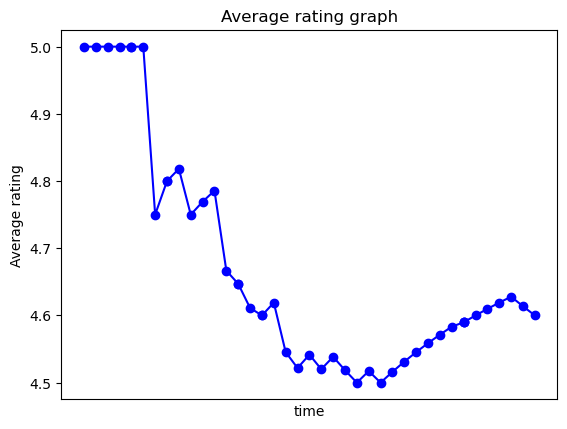

In [27]:
# Extract x and y values
x_values = [row.reviewTimeStamp for row in plot_val]
y_values = [row.cumulative_avg for row in plot_val]

# Plot the data as a line graph
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
plt.xlabel("time")
plt.ylabel("Average rating")
plt.title("Average rating graph")
plt.xticks([])
#plt.grid(True)
plt.show()

### Ranking logic for product category (For quality rank and popular rank)

In [147]:
combined_df = review_df.join(metadata_df_2.select("brand","main_cat","asin","title"), "asin")
combined_df.select('main_cat').distinct().collect()

[Row(main_cat='Computers'),
 Row(main_cat='All Electronics'),
 Row(main_cat='Home Audio & Theater'),
 Row(main_cat='Pet Supplies'),
 Row(main_cat='Toys & Games'),
 Row(main_cat='Baby'),
 Row(main_cat='Sports & Outdoors'),
 Row(main_cat='Grocery'),
 Row(main_cat='Automotive'),
 Row(main_cat='Books'),
 Row(main_cat='Amazon Home'),
 Row(main_cat='Industrial & Scientific'),
 Row(main_cat='Health & Personal Care'),
 Row(main_cat='Cell Phones & Accessories'),
 Row(main_cat='Arts, Crafts & Sewing'),
 Row(main_cat='Tools & Home Improvement'),
 Row(main_cat='All Beauty'),
 Row(main_cat='Office Products'),
 Row(main_cat='Appliances'),
 Row(main_cat='Camera & Photo'),
 Row(main_cat='Musical Instruments'),
 Row(main_cat='AMAZON FASHION'),
 Row(main_cat='NA_CATEGORY')]

In [148]:
combined_main_df = avg_ratings_df.join(combined_df.select("brand","main_cat","asin"),"asin","inner").dropDuplicates().na.drop()
#combined_main_df.show()

In [149]:
combined_main_df = combined_main_df.withColumn('rating_sum',F.col('total_reviews')*F.col('weighted_avg_rating'))
#combined_main_df.show()
# Create a WindowSpec for ranking based on the "value" column within each group
window_spec = Window.partitionBy("main_cat").orderBy(F.col("rating_sum").desc())

combined_main_df = combined_main_df.withColumn("popular_rank",F.rank().over(window_spec))
combined_main_df = combined_main_df.dropDuplicates()

In [150]:
# Create a WindowSpec for ranking based on the "value" column within each group
window_spec = Window.partitionBy("main_cat").orderBy(F.col("total_reviews").asc())

# Add a new column "rank" based on the "value" column within each group
combined_main_df = combined_main_df.withColumn("buy_rank", F.rank().over(window_spec))

combained_main_df = combined_main_df.dropDuplicates()

#combained_main_df.show()

In [151]:
# Create a WindowSpec for ranking based on the "value" column within each group
window_spec = Window.partitionBy("main_cat").orderBy(F.col("weighted_avg_rating").asc())

# Add a new column "rank" based on the "value" column within each group
combined_main_df = combined_main_df.withColumn("rating_rank", F.rank().over(window_spec))

combined_main_df = combined_main_df.dropDuplicates()

#combined_main_df.select('asin','main_cat','buy_rank','rating_rank').show()

In [152]:
combined_main_df = combined_main_df.withColumn('overall_score',F.col('buy_rank')*0.7+F.col('rating_rank')*0.3)


# Create a WindowSpec for ranking based on the "value" column within each group
window_spec = Window.partitionBy("main_cat").orderBy(F.col("overall_score").desc())

# Add a new column "rank" based on the "value" column within each group
combined_main_df = combined_main_df.withColumn("cat_rank", F.rank().over(window_spec))

combined_main_df = combined_main_df.dropDuplicates().na.drop(subset=['brand'])

combined_main_df.select('asin','main_cat','overall_score','cat_rank','popular_rank').show(truncate=False)

+----------+--------------+------------------+--------+------------+
|asin      |main_cat      |overall_score     |cat_rank|popular_rank|
+----------+--------------+------------------+--------+------------+
|B008ZVLX48|AMAZON FASHION|4.1               |1       |1           |
|B009VBI88A|AMAZON FASHION|3.8               |2       |3           |
|B00FNJD2Y4|AMAZON FASHION|3.6999999999999997|3       |2           |
|B00GWY4EMS|AMAZON FASHION|3.3               |4       |4           |
|B00915W2P6|AMAZON FASHION|1.9               |5       |5           |
|B0144B8PSY|AMAZON FASHION|1.9               |5       |5           |
|B00AUNNAVS|All Beauty    |24.099999999999998|1       |2           |
|B01D3R68VQ|All Beauty    |21.799999999999997|2       |1           |
|B015AQ7INA|All Beauty    |21.5              |3       |4           |
|B00DNCJNFA|All Beauty    |21.099999999999998|4       |8           |
|B0009H79PI|All Beauty    |21.0              |5       |3           |
|B00LZ76BNW|All Beauty    |20.0999

## Brand, category analysis

In [153]:
brand_df = combined_df.drop('asin')
avg_ratings_df_with_brands = brand_df.groupBy("brand").agg(
    F.avg("overall").alias("avg_rating"),
    F.count("overall").alias("total_reviews"),
     (F.sum(F.col("overall") * F.col("vote")) / F.sum("vote")).alias("weighted_avg_rating"),
    F.sum("vote").alias("total_votes"),
    (F.avg("sentiment")*100).alias("likeness"),
    ((F.sum(F.col("sentiment")*F.col("vote"))/F.sum("vote"))*100).alias("weighted_likeness")
)
avg_ratings_df_with_brands = avg_ratings_df_with_brands.join(combined_df.select("brand","main_cat"),"brand")

In [154]:

avg_ratings_df_with_brands = avg_ratings_df_with_brands.withColumn('rating_sum',F.col('total_reviews')*F.col('weighted_avg_rating'))

# Create a WindowSpec for ranking based on the "value" column within each group
window_spec = Window.partitionBy("main_cat").orderBy(F.col("rating_sum").desc())

avg_ratings_df_with_brands = avg_ratings_df_with_brands.withColumn("popular_rank",F.rank().over(window_spec))
avg_ratings_df_with_brands = avg_ratings_df_with_brands.dropDuplicates()
#avg_ratings_df_with_brands.select('brand','main_cat','rating_sum','popular_rank').show()

In [155]:
# Create a WindowSpec for ranking based on the "value" column within each group
window_spec = Window.partitionBy("main_cat").orderBy(F.col("total_reviews").asc())

# Add a new column "rank" based on the "value" column within each group
avg_ratings_df_with_brands = avg_ratings_df_with_brands.withColumn("buy_rank", F.rank().over(window_spec))

avg_ratings_df_with_brands = avg_ratings_df_with_brands.dropDuplicates()

#avg_ratings_df_with_brands.show()

In [156]:
# Create a WindowSpec for ranking based on the "value" column within each group
window_spec = Window.partitionBy("main_cat").orderBy(F.col("weighted_avg_rating").asc())

# Add a new column "rank" based on the "value" column within each group
avg_ratings_df_with_brands = avg_ratings_df_with_brands.withColumn("rating_rank", F.rank().over(window_spec))

avg_ratings_df_with_brands = avg_ratings_df_with_brands.dropDuplicates()

#avg_ratings_df_with_brands.select('brand','main_cat','buy_rank','rating_rank').show()

In [157]:
avg_ratings_df_with_brands = avg_ratings_df_with_brands.withColumn('overall_score',F.col('buy_rank')*0.7+F.col('rating_rank')*0.3)


# Create a WindowSpec for ranking based on the "value" column within each group
window_spec = Window.partitionBy("main_cat").orderBy(F.col("overall_score").desc())

# Add a new column "rank" based on the "value" column within each group
avg_ratings_df_with_brands = avg_ratings_df_with_brands.withColumn("cat_rank", F.rank().over(window_spec))

avg_ratings_df_with_brands = avg_ratings_df_with_brands.dropDuplicates().na.drop(subset=['main_cat','brand'])

avg_ratings_df_with_brands.select('brand','main_cat','cat_rank','popular_rank').show(truncate=False)

+---------------------------+--------------+--------+------------+
|brand                      |main_cat      |cat_rank|popular_rank|
+---------------------------+--------------+--------+------------+
|NA_BRAND                   |AMAZON FASHION|1       |1           |
|XO                         |AMAZON FASHION|2       |24          |
|Love+Grace                 |AMAZON FASHION|3       |37          |
|Ownshop                    |AMAZON FASHION|4       |25          |
|Whirlpool                  |All Beauty    |1       |1           |
|Supco                      |All Beauty    |2       |9           |
|ERP                        |All Beauty    |3       |31          |
|GE                         |All Beauty    |4       |8           |
|Kenmore                    |All Beauty    |5       |52          |
|BestAir                    |All Beauty    |6       |54          |
|HFM                        |All Beauty    |7       |447         |
|NA_BRAND                   |All Beauty    |8       |72       

## Inference Cell - Given a product we will present the following - showing title, brand name, category name.
### 1. Average rating.
### 2. Average sentiment (Likeness)
### 3. Weighted average rating (Calculated on the basis of votes)
### 4. Weighted average sentiment (Calculated on the basis of votes)
### 5. Rating distribution
### 6. Rating progression of a product over time as a plot.
### 7. Rank for the product in the main_category
### 8. Brand info

For inference please enter a product id B00FNJD2Y4


PRODUCT INFO:
Title of the product 43.0
Avergae rating of product 4.777777777777778
Weight average of the product 4.777777777777778
% of people liking the product 100.0
% of people liking the product (adjusted by votes) 100.0
Rank of the product by popularity 4 in AMAZON FASHION
Rank of the product by quality Row(asin='B00FNJD2Y4', avg_rating=4.777777777777778, total_reviews=9, weighted_avg_rating=4.777777777777778, total_votes=9.0, likeness=100.0, weighted_likeness=100.0, brand='NA_BRAND', main_cat='AMAZON FASHION', rating_sum=43.0, popular_rank=2, buy_rank=4, rating_rank=3, overall_score=3.6999999999999997, cat_rank=3) in AMAZON FASHION
Rating distribution for the product {'1.0': None, '2.0': None, '3.0': None, '4.0': 2, '5.0': 7}


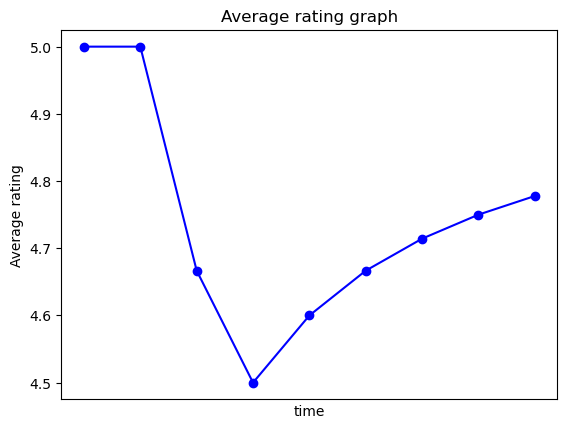

BRAND INFO:
Brand name is NA_BRAND
Average rating of brand 3.9763071895424837
Weight average of the brand 3.7445103857566764
% of people liking the brand 76.28676470588235
% of people liking the brand (adjusted by votes) 70.64292779426312
Rank of the brand by popularity 1 in AMAZON FASHION
Rank of the brand by quality 1 in AMAZON FASHION


In [159]:
productId = input("For inference please enter a product id")

###combained_main_df contains 1, 2, 3, 4, and 6
result_1 = combined_main_df.filter(col('asin')==productId)
result_1_ex = result_1.first()
plot_val = df.filter(col('asin')==productId).select("reviewTimeStamp","cumulative_avg").orderBy("reviewTimeStamp").collect()
result2 = result_df.filter(col('asin')==productId)
result3 = avg_ratings_df_with_brands.filter((col('brand')==result_1_ex[7]) & (col('main_cat')==result_1_ex[8]))

result_2_ex = result2.first()
result_3_ex = result3.first()

# Extract x and y values
x_values = [row.reviewTimeStamp for row in plot_val]
y_values = [row.cumulative_avg for row in plot_val]

# Plot the data as a line graph

print("PRODUCT INFO:")
print(f"Title of the product {result_1_ex[9]}")
print(f"Avergae rating of product {result_1_ex[1]}")
print(f"Weight average of the product {result_1_ex[3]}")
print(f"% of people liking the product {result_1_ex[5]}")
print(f"% of people liking the product (adjusted by votes) {result_1_ex[6]}")
print(f"Rank of the product by popularity {result_1_ex[11]} in {result_1_ex[8]}")
print(f"Rank of the product by quality {result_1_ex} in {result_1_ex[8]}")

print(f"Rating distribution for the product {result_2_ex[1]}")

plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
plt.xlabel("time")
plt.ylabel("Average rating")
plt.title("Average rating graph")
plt.xticks([])
#plt.grid(True)
plt.show()

print("BRAND INFO:")
print(f"Brand name is {result_3_ex[0]}")
print(f"Average rating of brand {result_3_ex[1]}")
print(f"Weight average of the brand {result_3_ex[3]}")
print(f"% of people liking the brand {result_3_ex[5]}")
print(f"% of people liking the brand (adjusted by votes) {result_3_ex[6]}")
print(f"Rank of the brand by popularity {result_3_ex[9]} in {result_3_ex[7]}")
print(f"Rank of the brand by quality {result_3_ex[13]} in {result_3_ex[7]}")

## Recommendation system code starts We will use ALS algorithm for collaborative filtering

## What is collaborative filtering?
Collaborative filtering is a technique used in recommendation systems to predict a user's preferences or interests by leveraging the preferences or behaviors of other users. How do we achieve this? Using reviews of products by ofcourse.

### User-Based Collaborative Filtering:

Idea: Recommends items based on the preferences of users who are similar to the target user.
Process: Identify users with similar preferences to the target user. Recommend items that those similar users liked but that the target user has not purchased YET. (See this is incomplete here, because we don't have the entire transaction data).

### Item-Based Collaborative Filtering:

Idea: Recommends items that are similar to items the target user has liked or interacted with in the past.
Process: Identify items that are similar to those the target user has already liked or interacted with. Recommend these similar items to the target user.

In [161]:
rec_rev_df = review_df.groupBy('reviewerID').agg(collect_list('asin').alias('bought_products'))

In [162]:
rec_rev_df.show()

+--------------------+--------------------+
|          reviewerID|     bought_products|
+--------------------+--------------------+
|A0001528BGUBOEVR6T5U|        [B00MVVITWC]|
|A00032921HLX2KJJVXRS|        [B0045LLC7K]|
|A001170867ZBE9FORRQL|        [B009HQGFX4]|
|A0064174TU5Q70UXX2M9|        [B01CKFSCOS]|
|A0096681Y127OL1H8W3U|[B0014CN8Y8, B001...|
|A0103047AS0C8QKUI0X2|        [B009PCI2JU]|
|A0122375SQ8Z42DUL03J|        [B001TH7H04]|
|A0123039S3EWL909O8SC|        [B01CA34OZG]|
|A0129433AZJVRKW94GP5|        [B00FEZNXRI]|
|A01486289FT2I09IRQ7C|        [B00QXYDZZE]|
|A01704365WXWXHQIZMHJ|[B009CETUN8, B00H...|
|A0172070TE3H35IHBV14|        [B00DT5746Q]|
|A0172676AYM41Z1T4K0V|        [B000FH6GB0]|
|A017868617BH3ZDM3WFJ|        [B011J74OTA]|
|A0197045D9X4GCE129IL|        [B01D151EFA]|
|A0220159ZRNBTRKLG08H|        [B00MU2WHFM]|
|A02429137JUJG115O90L|        [B00EN8NV60]|
|A0248167KKWYJWT5OHOM|        [B006WONMRQ]|
|A0255765B0FOF6603EJP|        [B00DZU8U36]|
|A0261431Y0V4MHWY4B7W|        [B

In [284]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
data = review_df.select("reviewerID", "asin", "overall")

indexer_reviewer = StringIndexer(inputCol="reviewerID", outputCol="reviewerIDIndex").fit(data)
indexer_asin = StringIndexer(inputCol="asin", outputCol="asinIndex").fit(data)

data_indexed = indexer_reviewer.transform(indexer_asin.transform(data))

# Split the data into training and testing sets
(trainingData, testData) = data_indexed.randomSplit([0.8, 0.2])


# Build the recommendation model using ALS
als = ALS(maxIter=10, regParam=0.05, rank=20, userCol="reviewerIDIndex", itemCol="asinIndex", ratingCol="overall", coldStartStrategy="drop")
model = als.fit(trainingData)

# Evaluate the model on the test set
predictions = model.transform(testData)

# Evaluate using RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 3.835866196251924


### Very high RMSE (Our observations)
1. There's two many products, and not sufficient data points for the ratings.. i.e. data is VERY SPARSE.
2. The features used to represent users and items may not capture the underlying patterns or preferences effectively.

In [285]:
predictions.show()

+--------------+----------+-------+---------+---------------+-----------+
|    reviewerID|      asin|overall|asinIndex|reviewerIDIndex| prediction|
+--------------+----------+-------+---------+---------------+-----------+
|A3P9GXL2BDXKQF|B004XLE0I0|    4.0|   1580.0|          358.0|  2.5919213|
| AR8AC8KLBQJVT|B00L4GDO34|    5.0|   2142.0|          406.0|  0.7178713|
|A347YYQI2YXNK2|B00L4GDO34|    5.0|   2142.0|         1212.0| -1.5146973|
|A3HLIVR8UY72P6|B00O7U6I0A|    5.0|    148.0|         1294.0|  1.5149769|
| A7ZTFAIY40BG9|B00N9DLM1Q|    4.0|   1591.0|         1396.0|-0.42266208|
| AVBBCE17U5204|B00V9ID8TW|    1.0|   9427.0|         1546.0|-0.19954652|
| A18KHSTC0MXIV|B00HNEJHSM|    5.0|   4900.0|         1743.0|  3.4458616|
|A3JX1D26WFEXOS|B00N9DLM1Q|    5.0|   1591.0|         3283.0|  1.0481702|
| AD44H3YP65YHL|B004XLE0I0|    5.0|   1580.0|         3670.0|-0.37050393|
|A1E0HMNY2RE294|B00DZU7LGS|    5.0|   3749.0|         5038.0| -0.4471658|
|A1HX8XOQCWR43Y|B004XLE0I0|    5.0|   

### There's a smaller dataset in which each product is rated atleast n times called n-core dataset. This will decrease the sparseness

In [164]:
app_review_df = spark.read.json('D:\\DE\\Appliances_5.json')

### Prepare inverse dictionaries for understanding inferences.

In [166]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
data = app_review_df.select("reviewerID", "asin", "overall")

indexer_reviewer = StringIndexer(inputCol="reviewerID", outputCol="reviewerIDIndex").fit(data)
indexer_asin = StringIndexer(inputCol="asin", outputCol="asinIndex").fit(data)

data_indexed = indexer_reviewer.transform(indexer_asin.transform(data))

In [167]:
data_indexed.show(10)

+--------------+----------+-------+---------+---------------+
|    reviewerID|      asin|overall|asinIndex|reviewerIDIndex|
+--------------+----------+-------+---------+---------------+
|A34A1UP40713F8|B00009W3I4|    5.0|     41.0|           24.0|
|A1AHW6I678O6F2|B00009W3PA|    5.0|     19.0|           28.0|
| A8R48NKTGCJDQ|B00009W3PA|    5.0|     19.0|           43.0|
| AR3OHHHW01A8E|B00009W3PA|    5.0|     19.0|           45.0|
|A2CIEGHZ7L1WWR|B00009W3PA|    5.0|     19.0|           22.0|
|A1RQQV9HYHDHDN|B00009W3PA|    5.0|     19.0|           33.0|
|A1OB2H416ARLFJ|B0009GVYNW|    4.0|     42.0|           32.0|
|A3LGZ8M29PBNGG|B000N6302Q|    2.0|      8.0|           25.0|
|A3LGZ8M29PBNGG|B000N6302Q|    2.0|      8.0|           25.0|
|A3SM7H70QI3TY8|B000N6302Q|    1.0|      8.0|           42.0|
+--------------+----------+-------+---------+---------------+
only showing top 10 rows



In [168]:
reviewer_extract = data_indexed.select("reviewerIDIndex", "reviewerID").rdd.collectAsMap()
product_extract = data_indexed.select("asinIndex", "asin").rdd.collectAsMap()

In [169]:
# Split the data into training and testing sets
(trainingData, testData) = data_indexed.randomSplit([0.8, 0.2])


# Build the recommendation model using ALS
als = ALS(maxIter=10, regParam=0.05, rank=20, userCol="reviewerIDIndex", itemCol="asinIndex", ratingCol="overall", coldStartStrategy="drop")
model = als.fit(trainingData)

# Evaluate the model on the test set
predictions = model.transform(testData)

# Evaluate using RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="overall", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.24736820121754927


In [170]:
model.save('recommendation_model')

In [171]:
predictions.show()

+--------------+----------+-------+---------+---------------+----------+
|    reviewerID|      asin|overall|asinIndex|reviewerIDIndex|prediction|
+--------------+----------+-------+---------+---------------+----------+
| AFUVGAUNQVT0S|B00DM8KQ2Y|    5.0|     31.0|           27.0| 4.9467645|
|A3GP2HMB2AFOKF|B00W4YKCGC|    5.0|     26.0|           12.0|   3.94891|
|A34A1UP40713F8|B000VL060M|    5.0|     27.0|           24.0| 4.9379067|
|A3B1B4E184FSUZ|B000VL060M|    5.0|     27.0|           39.0| 4.9829965|
|A3H61AMBJ177DG|B00W4YKCGC|    5.0|     26.0|           40.0| 4.5555973|
|A2CIEGHZ7L1WWR|B00P9C66PM|    5.0|     12.0|           22.0| 4.7369494|
|A1WD61B0C3KQZB|B0014CN8Y8|    4.0|      1.0|            1.0|  3.988245|
|A21TPY9BVC9IKZ|B0014CN8Y8|    5.0|      1.0|            2.0| 4.9843636|
|A21TPY9BVC9IKZ|B0014CN8Y8|    5.0|      1.0|            2.0| 4.9843636|
|A25C30G90PKSQA|B0014CN8Y8|    3.0|      1.0|            3.0| 2.9911475|
|A3TMNU7VNK5JJE|B0014CN8Y8|    3.0|      1.0|      

### Better predicted ratings and better RMSE

In [173]:
userRecommendations = model.recommendForAllUsers(5)

In [174]:
userRecommendations.show()

+---------------+--------------------+
|reviewerIDIndex|     recommendations|
+---------------+--------------------+
|             20|[{9, 5.011782}, {...|
|             40|[{10, 5.017848}, ...|
|             10|[{10, 5.066965}, ...|
|             30|[{26, 4.980724}, ...|
|              0|[{0, 4.986126}, {...|
|             31|[{29, 3.022098}, ...|
|              1|[{0, 3.9889052}, ...|
|             41|[{10, 5.1827087},...|
|             21|[{35, 4.9659767},...|
|             11|[{10, 5.106659}, ...|
|             12|[{15, 5.028592}, ...|
|             22|[{7, 4.990601}, {...|
|             32|[{42, 3.9764478},...|
|             42|[{36, 1.0038714},...|
|              2|[{0, 4.9861264}, ...|
|             13|[{15, 5.143532}, ...|
|              3|[{0, 2.9916787}, ...|
|             43|[{3, 4.961234}, {...|
|             23|[{2, 4.98523}, {3...|
|             33|[{3, 5.0001965}, ...|
+---------------+--------------------+
only showing top 20 rows



In [300]:
userRecommendations.printSchema()

root
 |-- reviewerIDIndex: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- asinIndex: integer (nullable = true)
 |    |    |-- rating: float (nullable = true)



In [177]:
rec = dict(userRecommendations.collect())

In [195]:
new_dict={}
for key,val in rec.items():
    result_dict=[]
    for i in val:
        result_dict.append(product_extract[i.asinIndex])
    new_dict[reviewer_extract[key]]=result_dict

In [199]:
userId=input()
print(new_dict[userId])

 A26Y776G7VVBCQ


['B00570RQ0A', 'B00CW0O1EW', 'B00P9C66PM', 'B001DPFP88', 'B0056I99WG']


#### Content based filtering using a cosine similarity
#### Here we are going to use very very simple similarity metric of similarity b/w titles..
#### We can add other features to derive the vector for similarity (Description or Features column in metadata_df)

In [202]:
title_df = metadata_df_2['asin','title']

In [203]:
title_df

DataFrame[asin: string, title: string]

In [208]:
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline  # Import the Pipeline class


tokenizer = Tokenizer(inputCol="title", outputCol="words")
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=120)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Apply TF-IDF and compute the cosine similarity
vector_pipeline = Pipeline(stages=[tokenizer,hashingTF,idf])

In [209]:
knn=vector_pipeline.fit(title_df)

In [210]:
title_df_2=knn.transform(title_df)

In [211]:
title_df_2.show()

+----------+--------------------+--------------------+--------------------+--------------------+
|      asin|               title|               words|         rawFeatures|            features|
+----------+--------------------+--------------------+--------------------+--------------------+
|7301113188|Tupperware Freeze...|[tupperware, free...|(120,[15,17,22,25...|(120,[15,17,22,25...|
|7861850250|2 X Tupperware Pu...|[2, x, tupperware...|(120,[0,10,11,12,...|(120,[0,10,11,12,...|
|8792559360|The Cigar - Momen...|[the, cigar, -, m...|(120,[6,15,17,28,...|(120,[6,15,17,28,...|
|9792954481|Caraselle 2X 50G ...|[caraselle, 2x, 5...|(120,[17,34,56,64...|(120,[17,34,56,64...|
|B00002N5EL|EATON Wiring 39CH...|[eaton, wiring, 3...|(120,[4,19,56,75,...|(120,[4,19,56,75,...|
|B00002N7HY|Leviton 5050 B01-...|[leviton, 5050, b...|(120,[0,6,10,15,1...|(120,[0,6,10,15,1...|
|B00002N7IL|Leviton 5206 50 A...|[leviton, 5206, 5...|(120,[0,3,6,10,14...|(120,[0,3,6,10,14...|
|B00002N9OE|Amerock BP5322-BJ.

In [212]:
#vec2 = target_vector
@udf(returnType=DoubleType())
def cosine_similarity(vec1,vec2):
    vec2=Vectors.sparse(len(vec2), [(i, val) for i, val in enumerate(vec2) if val != 0])
    # return float(vec2.norm(2))
    dot_product = float(vec1.dot(vec2))
    norm_product = float(vec1.norm(2) * vec2.norm(2))
    if norm_product == 0:
        return 0.0  # To handle division by zero
    else:
        return dot_product / norm_product

In [215]:
from pyspark.sql.functions import desc
recommend_product=input("Product ID: ")
target_item = title_df_2.filter(col('asin')==recommend_product).first()
target_vector=target_item[4]
df_result = title_df_2.withColumn("features2",expr(f"array({', '.join(map(str, target_vector.toArray()))})"))
df_result = df_result.withColumn("dotProduct",cosine_similarity('features','features2'))
product_recommendations = df_result.select('title','asin','dotProduct').dropDuplicates().orderBy(desc('dotProduct')).limit(6).select('asin','title').collect()
product_recommendations[:6]

Product ID:  B00004X18E


[Row(asin='B00004X18E', title='Electricord A1459-006-BL Appliance and Power Tool Extension Cord/3-Outlet, 6-Ft'),
 Row(asin='B00002N5EL', title='EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrome Power Outlet'),
 Row(asin='B004Q3YWYM', title='422748 Bosch Appliance Potentiometer'),
 Row(asin='B00UH2T6N8', title='Certified Appliance WM60SSL2PK Braided Stainless Steel Washing Machine Hose with Elbow - 60 in.'),
 Row(asin='B00CXY6A0A', title='Charman 800-58-A17-24 Yellow Coated Gas Connector with Straight Ball Valve - 5/8 in. OD 1/2 in. MIP x 1/2 in. FIP - 24 in. (Pack of 3)'),
 Row(asin='B001AHASM2', title='Unger 962680C Dryer Vent Brush 30 in.')]

### Final approach suggested..
### Hybrid approach:
1. If user is a new user i.e. cold start user and searches for a product - suggestion has to be done by similarity metric (here we only chose title because lot of cleaning of features, description columns is needed it has HTML tags and most of the fields are empty)
2. If user's transaction/order data is available, we can use collaborative filtering methods.. as mentioned above ALS (Alternating least squares)
3. Or show the best ranked products in each category, sub category (This is calculated during product portfolio).